In [1]:
#1. Import libraries
from pandas import read_excel
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib import pyplot
import numpy as np
from sklearn import metrics
from statsmodels.tsa.api import Holt

hui = read_excel('hui_daily2.xls', sheet_name = 'Data1', index_col = 0,
               header = 0, parse_dates = True, squeeze = True)

#Convert the date index (index refers to the date) into daily level 
hui.index = pd.DatetimeIndex(hui.index).to_period('D')


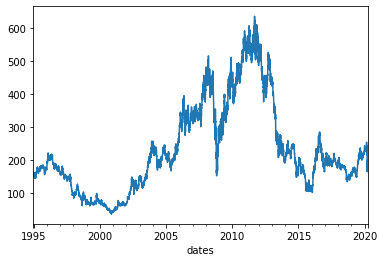

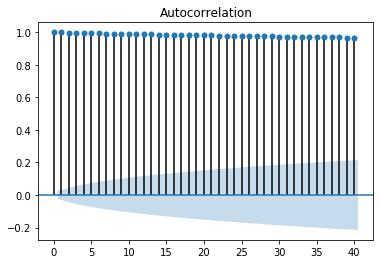

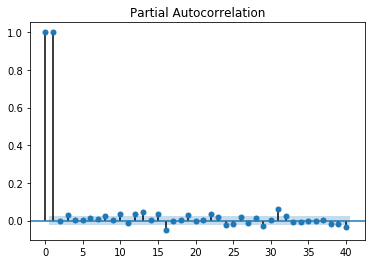

In [3]:
#2. Read data frame
#and make preliminary analysis 
#Retrieve time plot
hui.plot()
pyplot.show()

'''
#Plot time plot of 7MA and 2x12MA data
hui_7MA = read_excel('HUI_daily.xlsx', sheet_name = '7MA', header = 0, index_col = 0, sqeeze = True)
hui_12MA = read_excel('HUI_daily.xlsx', sheet_name = '2x12MA', header = 0, index_col = 0, sqeeze = True)

hui_7MA.plot()
pyplot.show()

hui_12MA.plot()
pyplot.show()
'''


#Use Autocorrelation and Partial Autocorrelation to identify the trend and seasonality
#This is prepared to adapting the model
plot_acf(hui, lags = 40)
plot_pacf(hui, lags = 40)
pyplot.show()
#From results, we can see that the trend exists whilst the seasonality does not.
#Therefore, Holt's Linear method is suggested.


C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


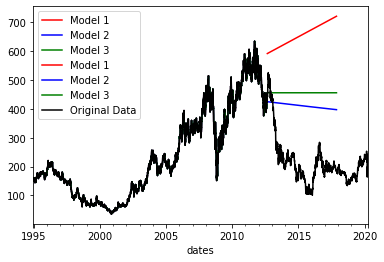

In [9]:
#3. Test the model by splitting the data into training and test set
#70% training and rest for test
train = hui[:4457]
test = hui[4457:]

#4. Build up potential Models and fit the training set to the model 
#Model 1: Additive trend
mod1 = Holt(train).fit(optimized = True)
#mod1.fittedvalues.plot(color = 'red', label = 'Model 1', legend = True)
#Fcast1 = mod1.forecast(len(test)).rename('Model 1') 

####The length of forecast results look different from the test set in length where the former one is more shorter visually 
###but all of them actually is in the same length (1909 data points).
###This situation occurs when date forecast results do not show the weekend which the transaction of market does not take place. 

#Model 2: Exponential Trend
mod2 = Holt(train, exponential = True).fit(optimized = True)
#mod2.fittedvalues.plot(color = 'blue', label = 'Model 2', legend = True)
#Fcast2 = mod2.forecast(len(test)).rename('Model 2')

#Model 3: Damped trend (less strong pattern of trend)
mod3 = Holt(train, damped = True).fit(optimized = True)
#mod3.fittedvalues.plot(color = 'green', label = 'Model 3', legend = True)
#Fcast3 = mod3.forecast(len(test)).rename('Model 3')  


#5. Do in-sample forecast over test set using 3 previous trained models
Fcast1 = mod1.forecast(len(test)).rename('Model 1')
Fcast2 = mod2.forecast(len(test)).rename('Model 2')
Fcast3 = mod3.forecast(len(test)).rename('Model 3')  

#6. 
#Visualise the fitted results of 3 models
mod1.fittedvalues.plot(color = 'red', label = 'Model 1', legend = True)
mod2.fittedvalues.plot(color = 'blue', label = 'Model 2', legend = True)
mod3.fittedvalues.plot(color = 'green', label = 'Model 3', legend = True)


#Visualise the in-sample forecast results
Fcast1.plot(color = 'red', legend = True)
Fcast2.plot(color = 'blue', legend = True)
Fcast3.plot(color = 'green', legend = True)

hui.plot(color = 'black', label = 'Original Data', legend = True)
pyplot.show()


In [12]:
#Check the type and values of the fitted and forecast value.
'''
print(mod1.fittedvalues); print(mod2.fittedvalues); print(mod3.fittedvalues)
print(Fcast1); print(Fcast2); print(Fcast3)
'''

'\nprint(mod1.fittedvalues); print(mod2.fittedvalues); print(mod3.fittedvalues)\nprint(Fcast1); print(Fcast2); print(Fcast3)\n'

The above plotting has a big issue: the real datetime index is not matched with forecasting inferred datetime index, which did not consider business situation.

In [13]:
#print(mod1.fittedvalues)
#print(Fcast1)
print(type(Fcast1))
#Let the datetime of forecast match that of test set.
Fcast1.index = test.index
Fcast2.index = test.index
Fcast3.index = test.index

<class 'pandas.core.series.Series'>


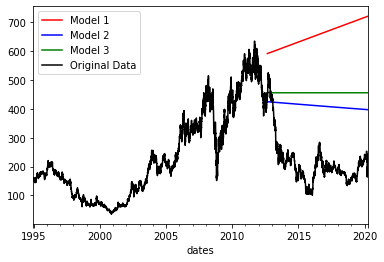

In [14]:
#Visualise the in-sample forecast results
Fcast1.plot(color = 'red', legend = True)
Fcast2.plot(color = 'blue', legend = True)
Fcast3.plot(color = 'green', legend = True)

hui.plot(color = 'black', label = 'Original Data', legend = True)
pyplot.show()

C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


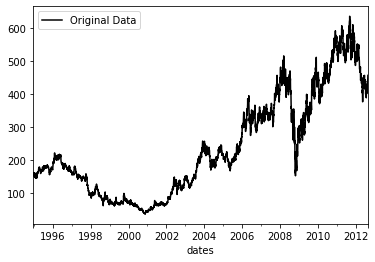

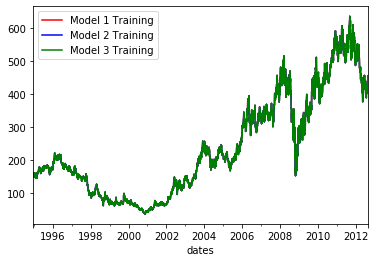

In [23]:
#6.a To prevent overlapping plot, here we seperate original training dataset from results of three models to plot
train = hui[:4457]
test = hui[4457:]

#Model 1: Additive trend
mod1 = Holt(train).fit(optimized = True)
Fcast1 = mod1.forecast(len(test)).rename('Model 1')

#Model 2: Exponential Trend
mod2 = Holt(train, exponential = True).fit(optimized = True)
Fcast2 = mod2.forecast(len(test)).rename('Model 2')

#Model 3: Damped trend (less strong pattern of trend)
mod3 = Holt(train, damped = True).fit(optimized = True)
Fcast3 = mod3.forecast(len(test)).rename('Model 3')  

#Show and compare the plot
train.plot(color = 'black', label = 'Original Data', legend = True)
pyplot.show()

mod1.fittedvalues.plot(color = 'red', label = 'Model 1 Training', legend = True)
mod2.fittedvalues.plot(color = 'blue', label = 'Model 2 Training', legend = True)
mod3.fittedvalues.plot(color = 'green', label = 'Model 3 Training', legend = True)
pyplot.show()


In [22]:
#7. Evaluate the models by various error indicators such as MSE or MAE and MAPE
#Define the function of error
def mape(true, pred):
    return np.mean(np.abs((true - pred) / true)) * 100
def errors(true, pred):
    MSE = metrics.mean_squared_error(true, pred)
    MAE = metrics.mean_absolute_error(true, pred)
    MAPE = mape(true, pred)
    return MSE, MAE, MAPE


train_e1 = errors(train, mod1.fittedvalues)
train_e2 = errors(train, mod2.fittedvalues)
train_e3 = errors(train, mod3.fittedvalues)
print('Training Set of Model 1: MSE, MAE and MAPE are {0}'.format(train_e1))
print('Training Set of Model 2: MSE, MAE and MAPE are {0}'.format(train_e2))
print('Training Set of Model 3 MSE, MAE and MAPE are {0}'.format(train_e3))

####
test_e1 = errors(test, Fcast1)
test_e2 = errors(test, Fcast2)
test_e3 = errors(test, Fcast3)
print('Test Set of Model 1: MSE, MAE and MAPE are {0}'.format(test_e1))
print('Test Set of Model 2: MSE, MAE and MAPE are {0}'.format(test_e2))
print('Test Set of Model 3 MSE, MAE and MAPE {0}'.format(test_e3))

Training Set of Model 1: MSE, MAE and MAPE are (46.97473361384059, 4.4097735314142374, 1.9000370992506164)
Training Set of Model 2: MSE, MAE and MAPE are (46.979226491493606, 4.406757553286409, 1.8961952756930374)
Training Set of Model 3 MSE, MAE and MAPE are (46.97774987204779, 4.408050418833973, 1.8969190015840343)
Test Set of Model 1: MSE, MAE and MAPE are (207600.2286165472, 444.2618508690043, 231.49003695650725)
Test Set of Model 2: MSE, MAE and MAPE are (44835.7185177458, 203.27637147045348, 106.32479107819941)
Test Set of Model 3 MSE, MAE and MAPE (65286.54949641929, 245.7939460291055, 128.71363895237488)


Summary: In terms of the plots, the training results have very few difference from the original one. This is reflected in very low level of error values in training set.
As for the performance on the test set, it comes to very significant difference from the reality, which we refer is overfitting.

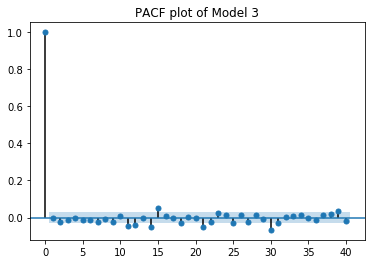

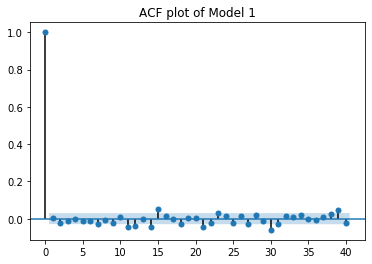

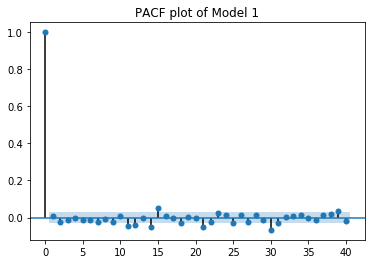

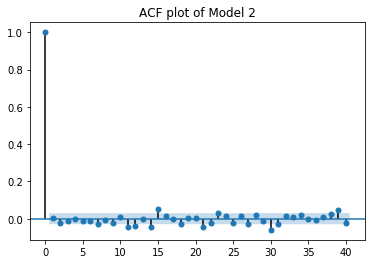

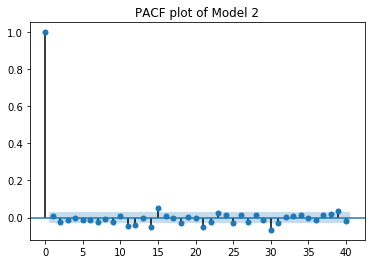

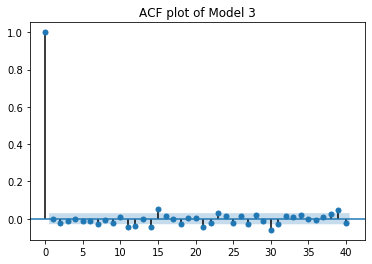

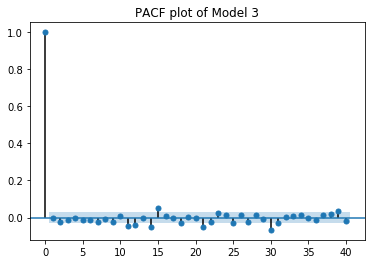

In [19]:
#6. Check the residuals of training dataset by time autocorrelation plot
#and see if there are some patterns that is not fully captured by our selected model
#Use .resid to obtain the residual data from the fitting/training model

resd1 = mod1.resid
resd2 = mod2.resid
resd3 = mod3.resid

plot_acf(resd1, lags = 40, title = 'ACF plot of Model 1')
plot_pacf(resd1, lags = 40, title = 'PACF plot of Model 1')

plot_acf(resd2, lags = 40, title = 'ACF plot of Model 2')
plot_pacf(resd2, lags = 40, title = 'PACF plot of Model 2')

plot_acf(resd3, lags = 40, title = 'ACF plot of Model 3')
plot_pacf(resd3, lags = 40, title = 'PACF plot of Model 3')

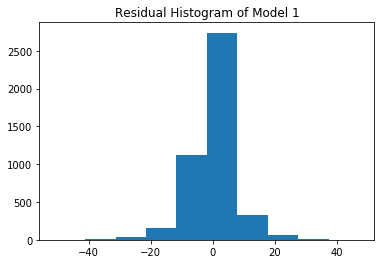

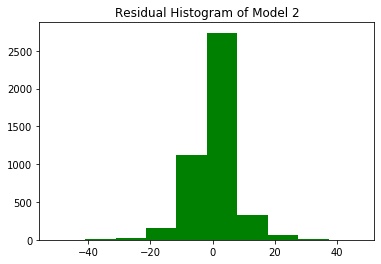

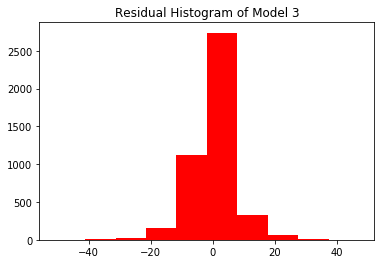

In [20]:
import matplotlib.pyplot as plt
plt.hist(resd1)
plt.title('Residual Histogram of Model 1')
plt.show()

plt.hist(resd2, facecolor = 'g')
plt.title('Residual Histogram of Model 2')
plt.show()

plt.hist(resd3, facecolor = 'r')
plt.title('Residual Histogram of Model 3')
plt.show()

C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


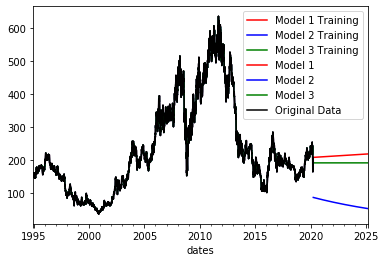

In [8]:
#Out-sample forecasting: Deploy 3 abovementioned model on full dataset
#This can happen when the model is trained and tuned very well and can be put into practice.
#4-a. Fit the dataset to the potential model

#Model 1: Additive-trended model
mod11 = Holt(hui).fit(optimized = True)

#Model 2: Exponential-trended model
mod22 = Holt(hui, exponential = True).fit(optimized = True)

#Model 3: Damped trend (less strong pattern of trend)
mod33 = Holt(hui, damped = True).fit(optimized = True)

#5. Do out-sample forecast over test set for 3 previous trained models
Fcast11 = mod11.forecast(1800).rename('Model 1')
Fcast22 = mod22.forecast(1800).rename('Model 2')
Fcast33 = mod33.forecast(1800).rename('Model 3')  

#6. Visualise the fitted results of 3 models
mod11.fittedvalues.plot(color = 'red', label = 'Model 1', legend = True)
mod22.fittedvalues.plot(color = 'blue', label = 'Model 2', legend = True)
mod33.fittedvalues.plot(color = 'green', label = 'Model 3', legend = True)

#Visualise the out-sample forecast results
Fcast11.plot(color = 'red', legend = True)
Fcast22.plot(color = 'blue', legend = True)
Fcast33.plot(color = 'green', legend = True)

hui.plot(color = 'black', label = 'Original Data', legend = True)
pyplot.show()
